In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
data = np.loadtxt('../dataset/training_data_LSTM_FS_1_belt.csv', delimiter=',', dtype='float32')
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

(1608, 13)
(402, 13)


In [3]:
n_input = 12     # 입력데이터의 속성 수
n_step = 5       # 한 번에 입력할 데이터 수
n_class = 11     # 결과값의 종류 수 (Activity 1~11)
batch_size = 1   # 배치 크기 (ex. n_step개 데이터 batch_size묶음이 1배치)
n_epoch = 50    # 총 학습 횟수

n_hidden = 64
learning_rate = 0.01

In [4]:
# epoch 당 batch 수 계산
train_batch = train.shape[0]//(batch_size*n_step)
print(train_batch)
test_batch = test.shape[0]//(batch_size*n_step)
print(test_batch)

321
80


In [5]:
x_train = train[:, :n_input]
y_train_temp = train[:, -1]

sess = tf.Session()
y_train_temp = np.subtract(y_train_temp, np.ones(y_train_temp.shape))
y_train_temp = tf.one_hot(y_train_temp, depth=n_class).eval(session=sess)

y_train = np.zeros([train_batch, n_class])
for i in range(train_batch):
    y_train[i] = y_train_temp[n_step * i]

x_train = x_train.tolist()
y_train = y_train.tolist()

print(len(x_train))
print(len(y_train))

1608
321


In [6]:
x_test = test[:, :n_input]
y_test_temp = test[:, -1]

#sess = tf.Session()
y_test_temp = np.subtract(y_test_temp, np.ones(y_test_temp.shape))
y_test_temp = tf.one_hot(y_test_temp, depth=n_class).eval(session=sess)

y_test = np.zeros([test_batch, n_class])
for i in range(test_batch):
    y_test[i] = y_test_temp[n_step * i]

x_test = x_test.tolist()
y_test = y_test.tolist()

print(len(x_test))
print(len(y_test))

402
80


In [7]:
# 현재 iteration의 batch를 반환하는 함수
def get_batch(x, y, iteration, size = batch_size):
  start = size*iteration
  batch_x = []
  batch_y = []
  for i in range(size):
    batch_x.append(x[(start+i)*n_step:(start+i+1)*n_step])
    batch_y.append(y[start+i])
  return batch_x, batch_y

In [8]:
# RNN 구성
X = tf.placeholder(tf.float32, [None, n_step, n_input], name='x')
Y = tf.placeholder(tf.int32, [None, n_class], name='y')

W = tf.Variable(tf.truncated_normal([n_hidden, n_class]))
b = tf.Variable(tf.truncated_normal([n_class]))

cell1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=0.7)
cell2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)

multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])

output, state = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
output = tf.transpose(output, [1,0,2])
output = output[-1]

model = tf.matmul(output, W) + b

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [10]:
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

epoch: 1, avg.loss: 2.622215
epoch: 2, avg.loss: 2.168701
epoch: 3, avg.loss: 1.989517
epoch: 4, avg.loss: 1.769290
epoch: 5, avg.loss: 1.670878
epoch: 6, avg.loss: 1.450808
epoch: 7, avg.loss: 1.318434
epoch: 8, avg.loss: 1.336429
epoch: 9, avg.loss: 1.200173
epoch: 10, avg.loss: 0.990355
epoch: 11, avg.loss: 0.982446
epoch: 12, avg.loss: 0.880620
epoch: 13, avg.loss: 0.641614
epoch: 14, avg.loss: 0.561151
epoch: 15, avg.loss: 0.655914
epoch: 16, avg.loss: 0.660117
epoch: 17, avg.loss: 0.643070
epoch: 18, avg.loss: 0.510724
epoch: 19, avg.loss: 0.465543
epoch: 20, avg.loss: 0.385042
epoch: 21, avg.loss: 0.667916
epoch: 22, avg.loss: 0.491604
epoch: 23, avg.loss: 0.612139
epoch: 24, avg.loss: 0.486887
epoch: 25, avg.loss: 0.448806
epoch: 26, avg.loss: 0.587179
epoch: 27, avg.loss: 0.388539
epoch: 28, avg.loss: 0.421516
epoch: 29, avg.loss: 0.403317
epoch: 30, avg.loss: 0.283682
epoch: 31, avg.loss: 0.324552
epoch: 32, avg.loss: 0.501751
epoch: 33, avg.loss: 0.460875
epoch: 34, avg.loss

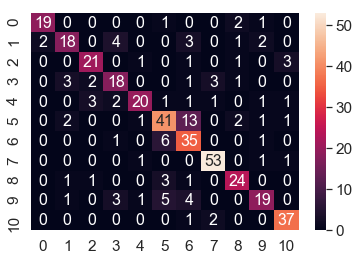

In [11]:
# 세션 실행
with tf.Session() as sess:
  tf.global_variables_initializer().run()

  # 학습
  for i in range(n_epoch):
    total_loss = 0
    for j in range(train_batch):
      batch_x, batch_y = get_batch(x_train, y_train, j)
      _, loss = sess.run([optimizer, cost], feed_dict={X: batch_x, Y: batch_y})
      total_loss += loss
    print('epoch: %d, avg.loss: %f'%(i+1, total_loss/train_batch)) 

  # 모델 테스트
  total_acc = 0
  for k in range(train_batch):
    test_x, test_y = get_batch(x_train, y_train, k)
    acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    total_acc += acc
  print('---train accuracy: %f,'%(total_acc/train_batch))

  # 테스트
  total_acc = 0
  for k in range(test_batch):
    test_x, test_y = get_batch(x_test, y_test, k)
    acc = sess.run(accuracy, feed_dict={X: test_x, Y: test_y})
    total_acc += acc
  print('---test accuracy: %f,'%(total_acc/test_batch))
    
  # confusion matrix
  train_x, train_y = get_batch(x_train, y_train, 0, train_batch)
  cm = tf.confusion_matrix(tf.argmax(train_y, 1), tf.argmax(sess.run(model, feed_dict={X: train_x, Y: train_y}), 1), n_class)
  test_x, test_y = get_batch(x_test, y_test, 0, test_batch)
  cm += tf.confusion_matrix(tf.argmax(test_y, 1), tf.argmax(sess.run(model, feed_dict={X: test_x, Y: test_y}), 1), n_class)
  df_cm = pd.DataFrame(sess.run(cm), range(n_class), range(n_class))
  # plt.figure(figsize = (10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    
  sess.close()